In [1]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
import time
from collections import Counter

In [2]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

for i in range(0,613):
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
FF_df = (FF_df-FF_df.mean())/FF_df.std()
TD_x_df = (TD_x_df-TD_x_df.mean())/TD_x_df.std()
TD_y_df = (TD_y_df-TD_y_df.mean())/TD_y_df.std()

outlier_column_indexes = set([])

index = 0
for value in TD_y_df.iloc[99]:
    if value > -1:
        outlier_column_indexes.add(index)
    index = index + 1

index = 0 
for value in TD_y_df.iloc[5]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
index = 0 
for value in TD_y_df.iloc[15]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
FF_df = FF_df.drop(outlier_column_indexes, axis=1)
TD_x_df = TD_x_df.drop(outlier_column_indexes, axis=1)
TD_y_df = TD_y_df.drop(outlier_column_indexes, axis=1)

for i in TD_y_df.columns:
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)

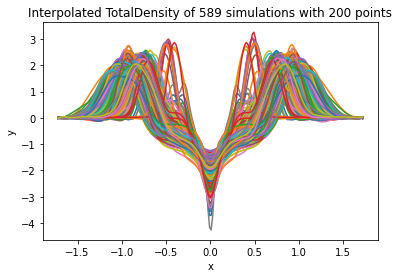

In [3]:
i = 0
for index in TD_x_df.columns:
    plt.plot(TD_x_df[index],TD_y_df[index])
    i = i + 1
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity of ' + str(i) + ' simulations with 200 points')
plt.show()

In [4]:
input_data = np.array(FF_df.iloc[: , :-14])
output_data_x = np.array(TD_x_df.iloc[: , :-14])
output_data_y = np.array(TD_y_df.iloc[: , :-14])
print(input_data.shape)
print(output_data_x.shape)
print(output_data_y.shape)

(1000, 575)
(200, 575)
(200, 575)


In [5]:
random.seed(42)
train = random.sample(range(0,input_data.shape[1]),int(input_data.shape[1]*0.8))
test = []
for number in range(0,input_data.shape[1]):
    if not number in train:
        test.append(number)

print(train)
print(len(train))
print(test)
print(len(test))

[114, 25, 281, 250, 228, 142, 104, 558, 89, 432, 32, 30, 95, 223, 238, 517, 27, 203, 429, 225, 459, 284, 6, 163, 565, 348, 553, 159, 220, 344, 568, 94, 389, 99, 367, 352, 270, 44, 470, 127, 387, 80, 300, 370, 196, 71, 46, 233, 296, 81, 560, 103, 542, 548, 464, 373, 166, 379, 363, 214, 273, 73, 175, 571, 83, 236, 194, 138, 506, 473, 327, 539, 285, 112, 350, 518, 431, 393, 397, 28, 117, 420, 16, 412, 161, 205, 137, 33, 108, 467, 482, 290, 448, 540, 490, 486, 335, 255, 202, 452, 468, 329, 234, 513, 135, 529, 126, 381, 287, 275, 134, 382, 299, 219, 554, 298, 204, 185, 501, 70, 260, 252, 528, 386, 24, 440, 56, 78, 321, 525, 405, 549, 216, 305, 564, 197, 195, 441, 239, 538, 128, 283, 5, 443, 369, 58, 349, 274, 384, 136, 497, 328, 174, 57, 150, 222, 533, 232, 1, 430, 368, 520, 256, 390, 91, 259, 54, 320, 152, 504, 409, 311, 101, 447, 191, 411, 82, 276, 271, 0, 306, 165, 511, 9, 421, 457, 157, 122, 29, 123, 483, 40, 43, 374, 248, 35, 272, 64, 65, 337, 243, 572, 84, 536, 435, 310, 442, 479, 496

In [6]:
train_input_values = []
for number in train:
    train_input_values.append(input_data[:,number])
    
train_output_values = []
for number in train:
    train_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))

test_input_values = []
for number in test:
    test_input_values.append(input_data[:,number])
    
test_output_values = []
for number in test:
    test_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))
    
train_input_values = np.array(train_input_values).astype(np.float32)
train_output_values = np.array(train_output_values).astype(np.float32)
test_input_values = np.array(test_input_values).astype(np.float32)
test_output_values = np.array(test_output_values).astype(np.float32)

print(train_input_values.shape)
print(train_output_values.shape)
print(test_input_values.shape)
print(test_output_values.shape)

(460, 1000)
(460, 400)
(115, 1000)
(115, 400)


In [7]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data')
    plt.show()
    
    return [average_loss, mode_loss, median_loss]

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(test_input_values)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = test_output_values[number][0:length]
        y_2 = test_output_values[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = test_output_values[index][0:length].tolist()
        t_y = test_output_values[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    number = 10
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 75
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 80
    prediction = model.predict(test_input_values)
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show()
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))

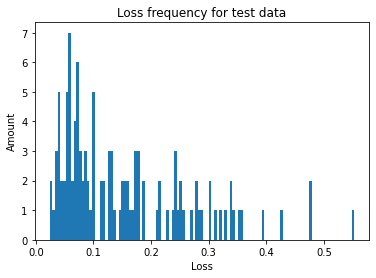

Loss is: 0.15319243709563493
Loss mode is: [(0.056, 3), (0.242, 3), (0.069, 3), (0.178, 2), (0.173, 2), (0.059, 2), (0.072, 2), (0.278, 2), (0.041, 2), (0.159, 2)]
Loss median is: 0.119
Used time: 340.14920139312744 seconds



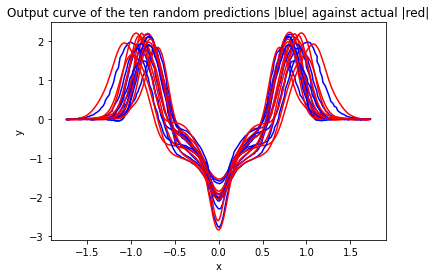

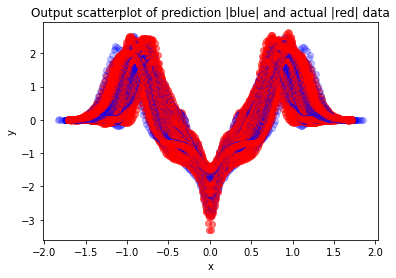

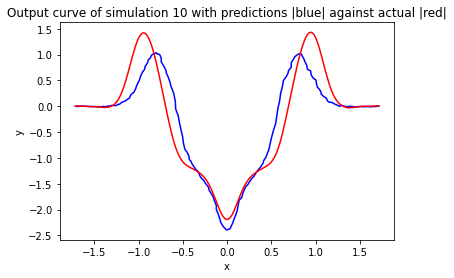

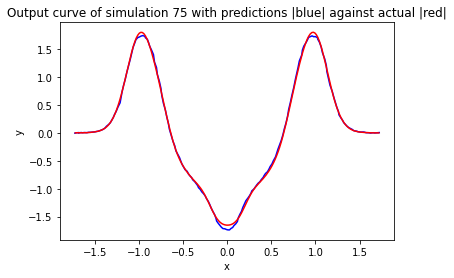

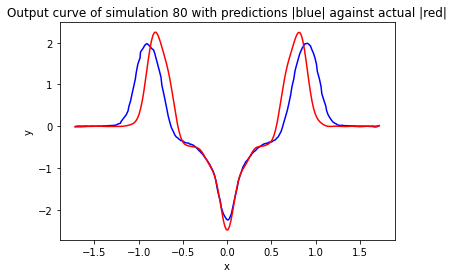

In [8]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="relu")(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

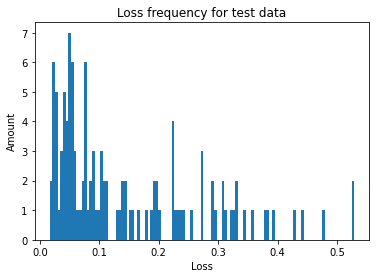

Loss average is: 0.14657003538333185
Loss mode is: [(0.34191, 1), (0.19677, 1), (0.06538, 1), (0.13767, 1), (0.02652, 1), (0.14242, 1), (0.04909, 1), (0.32208, 1), (0.0468, 1), (0.08384, 1)]
Loss median is: 0.09169
Used time: 593.1274588108063 seconds



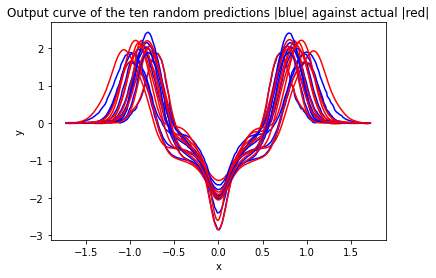

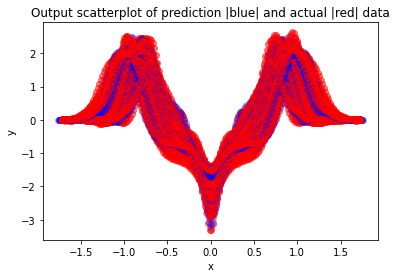

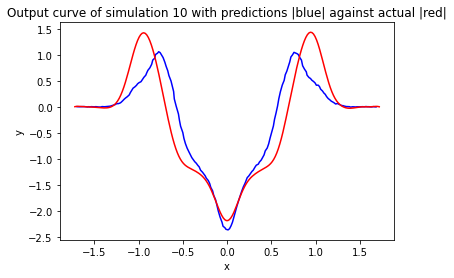

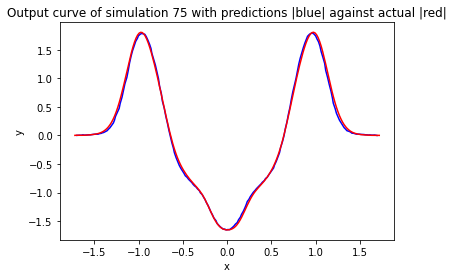

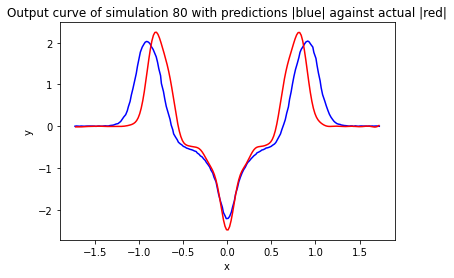

In [10]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="relu")(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=158, epochs=1000, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

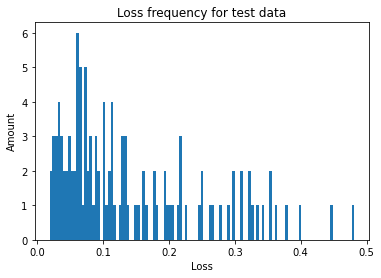

Loss average is: 0.14169800135201258
Loss mode is: [(0.10005, 1), (0.1598, 1), (0.13038, 1), (0.21226, 1), (0.06589, 1), (0.21896, 1), (0.09307, 1), (0.36414, 1), (0.06165, 1), (0.06605, 1)]
Loss median is: 0.10268
Used time: 523.086767911911 seconds



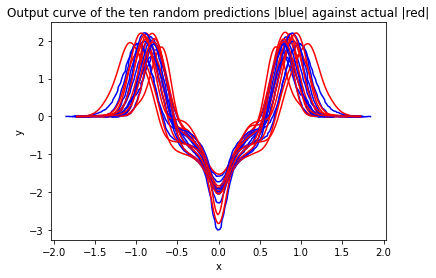

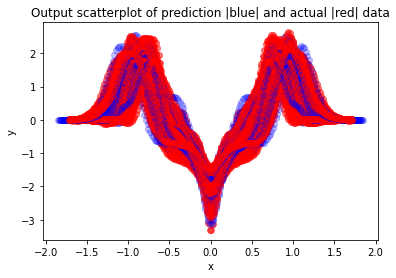

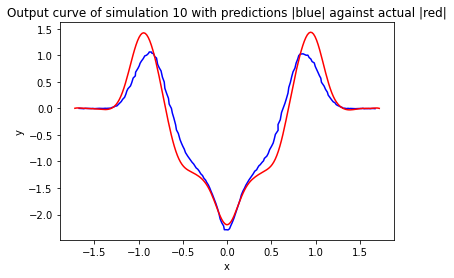

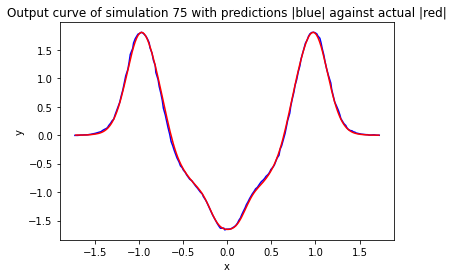

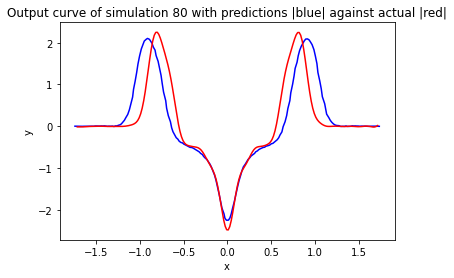

In [11]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="relu")(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=63, epochs=1000, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

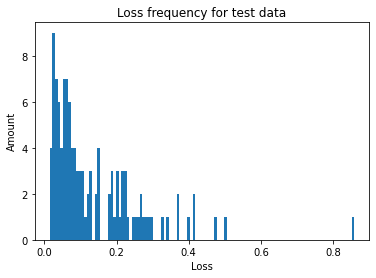

Loss average is: 0.13698721025871713
Loss mode is: [(0.22467, 1), (0.09389, 1), (0.04341, 1), (0.18347, 1), (0.01623, 1), (0.184, 1), (0.05325, 1), (0.14483, 1), (0.02686, 1), (0.02652, 1)]
Loss median is: 0.08558
Used time: 815.9553279876709 seconds



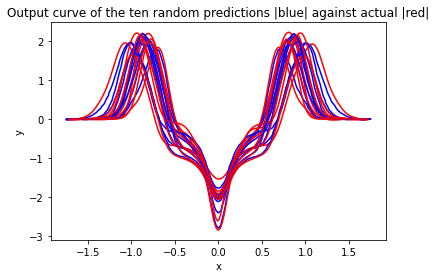

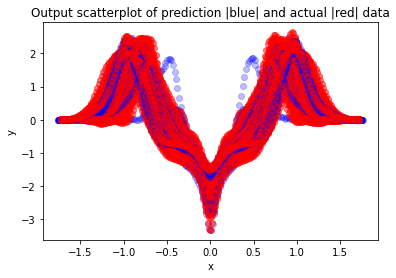

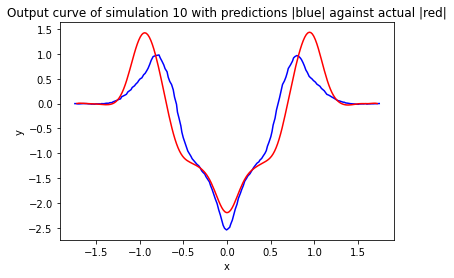

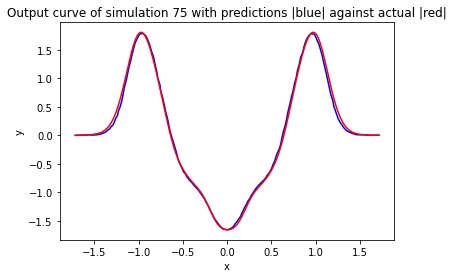

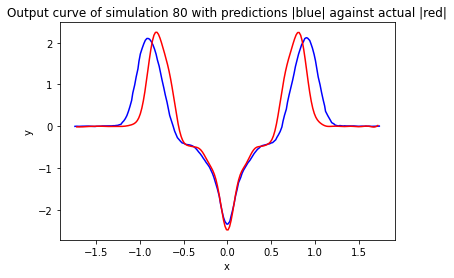

In [12]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="relu")(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="relu")(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=158, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

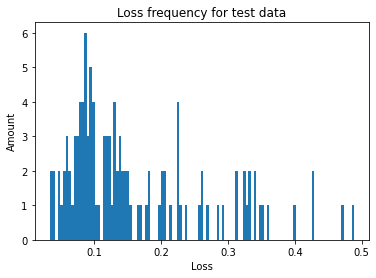

Loss average is: 0.16124309353407607
Loss mode is: [(0.11981, 1), (0.09602, 1), (0.13376, 1), (0.26134, 1), (0.08705, 1), (0.27088, 1), (0.09623, 1), (0.21251, 1), (0.05756, 1), (0.14404, 1)]
Loss median is: 0.12467
Used time: 435.93122482299805 seconds



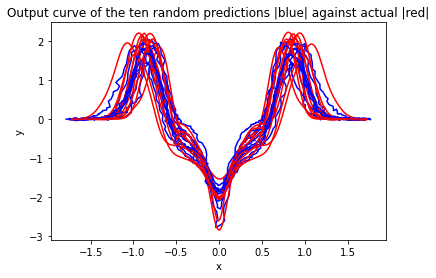

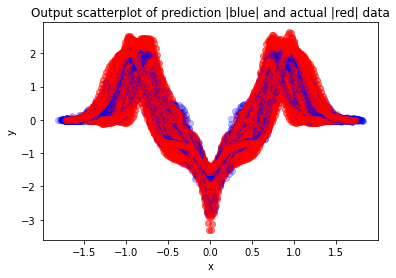

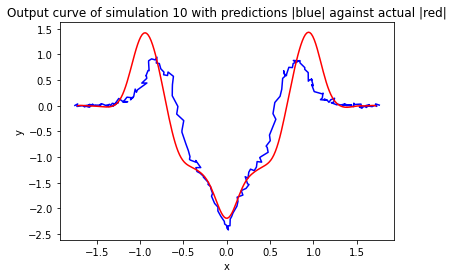

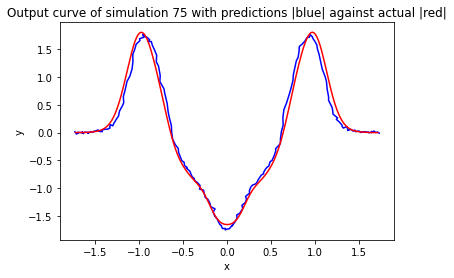

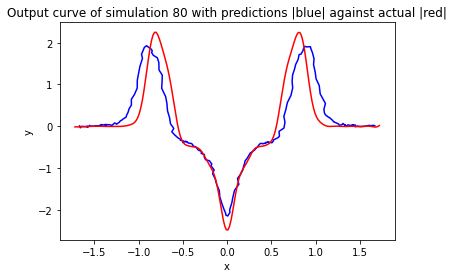

In [14]:
from keras.layers import LeakyReLU

general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000)(inputs)
x = layers.LeakyReLU(alpha=0.3)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.LeakyReLU(alpha=0.3)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.LeakyReLU(alpha=0.3)(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.LeakyReLU(alpha=0.3)(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=158, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

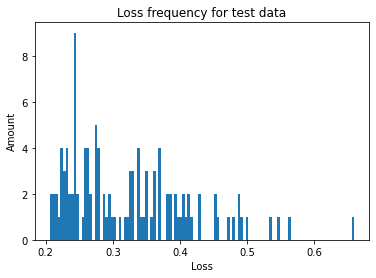

Loss average is: 0.3220574896156491
Loss mode is: [(0.33907, 2), (0.24358, 1), (0.2752, 1), (0.22809, 1), (0.48966, 1), (0.29247, 1), (0.49274, 1), (0.28555, 1), (0.28632, 1), (0.39163, 1)]
Loss median is: 0.29456
Used time: 115.42457175254822 seconds



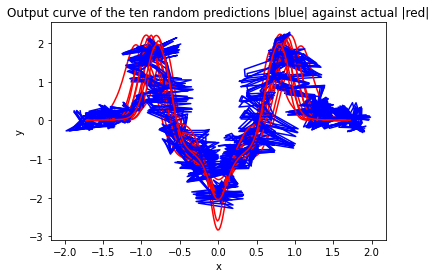

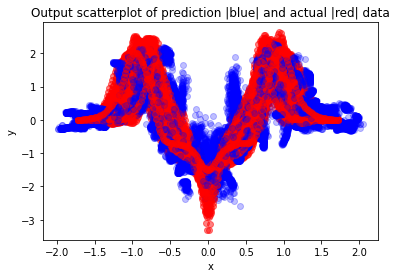

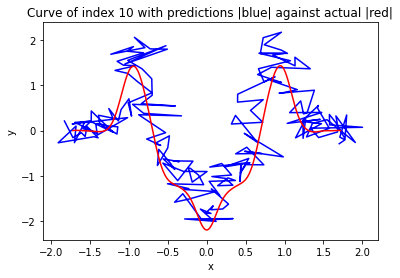

The loss of the curve 0.39252024181342776


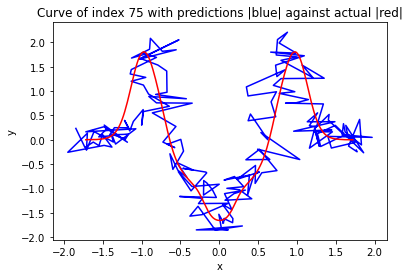

The loss of the curve 0.33670223880506583


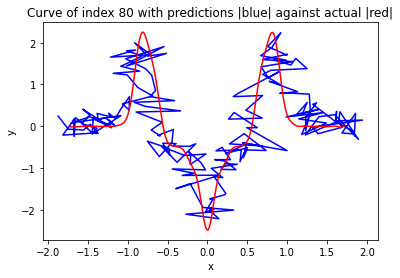

The loss of the curve 0.40881358888570296


In [8]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="elu")(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="elu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="elu")(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="elu")(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

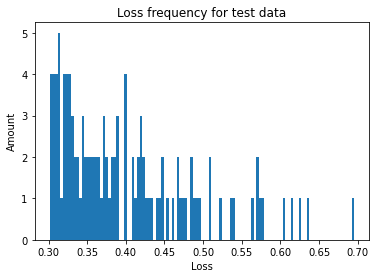

Loss average is: 0.39967979376346635
Loss mode is: [(0.32502, 1), (0.34345, 1), (0.30906, 1), (0.56943, 1), (0.37327, 1), (0.57099, 1), (0.36565, 1), (0.36956, 1), (0.4857, 1), (0.32875, 1)]
Loss median is: 0.37597
Used time: 140.43886423110962 seconds



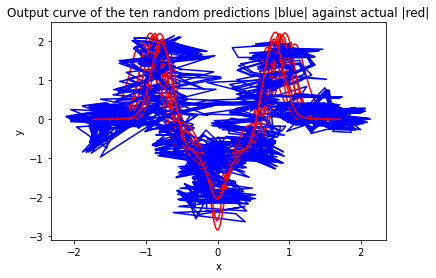

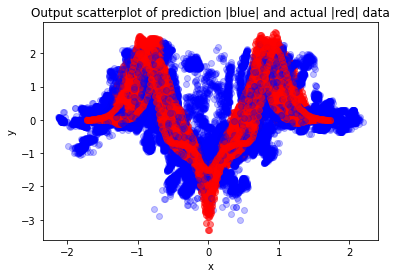

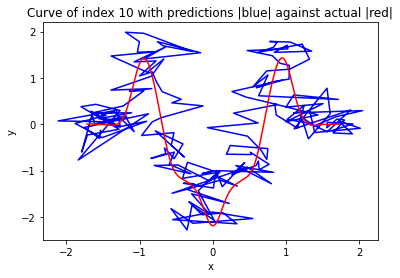

The loss of the curve 0.4169018952724062


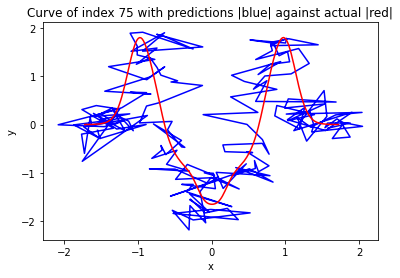

The loss of the curve 0.4106044249916961


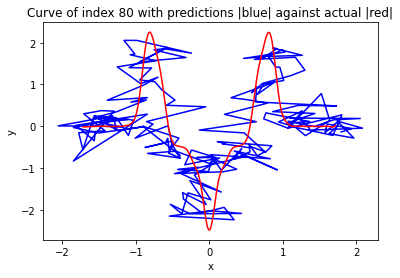

The loss of the curve 0.49193249970631375


In [9]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation="elu")(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="elu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="elu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation="elu")(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

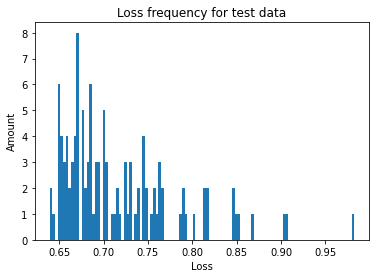

Loss average is: 0.7153039970586661
Loss mode is: [(0.65634, 1), (0.66892, 1), (0.6394, 1), (0.81453, 1), (0.67154, 1), (0.81686, 1), (0.70335, 1), (0.67189, 1), (0.74519, 1), (0.66641, 1)]
Loss median is: 0.69447
Used time: 200.3138587474823 seconds



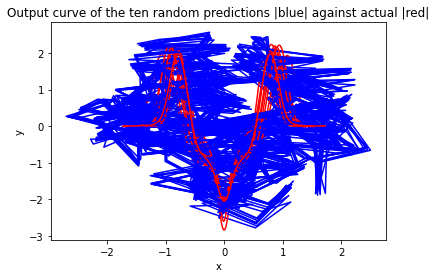

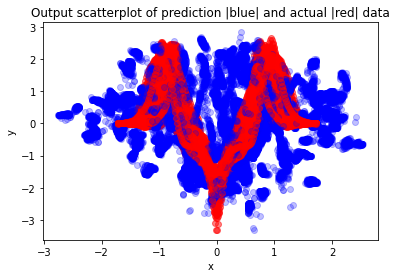

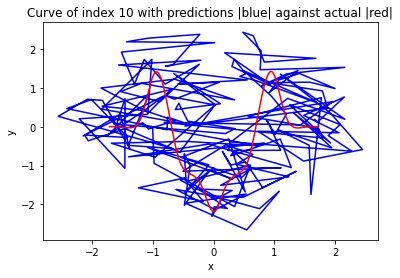

The loss of the curve 0.7023100557857673


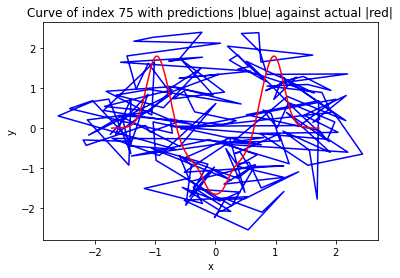

The loss of the curve 0.6927891351550763


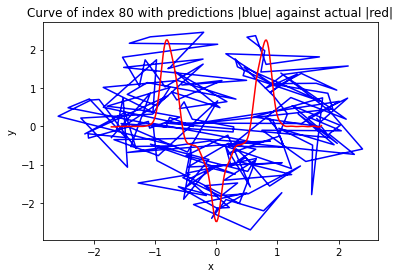

The loss of the curve 0.8163618074210557


In [10]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, kernel_initializer='lecun_normal', activation='selu')(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, kernel_initializer='lecun_normal', activation='selu')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, kernel_initializer='lecun_normal', activation='selu')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, kernel_initializer='lecun_normal', activation='selu')(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

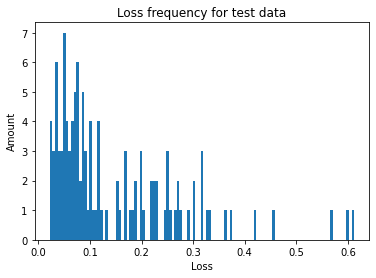

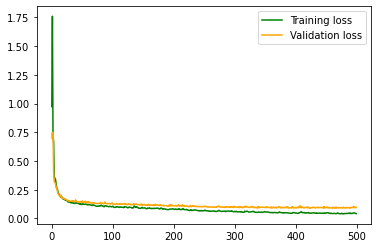

Loss average is: 0.14684979446215957
Loss mode is: [(0.29104, 1), (0.10369, 1), (0.36187, 1), (0.16041, 1), (0.05652, 1), (0.16679, 1), (0.09799, 1), (0.22671, 1), (0.03701, 1), (0.02773, 1)]
Loss median is: 0.09258
Used time: 385.2004053592682 seconds



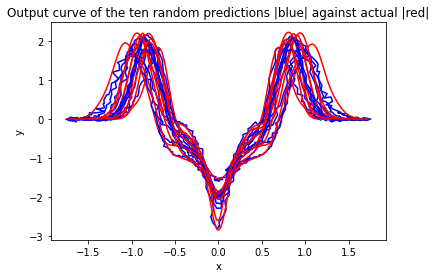

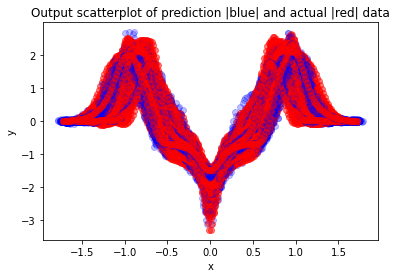

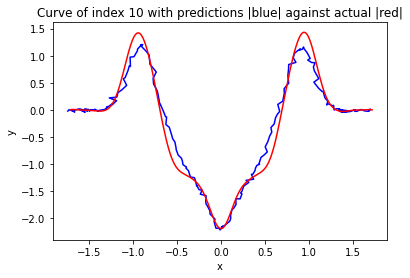

The loss of the curve 0.11486496740124641


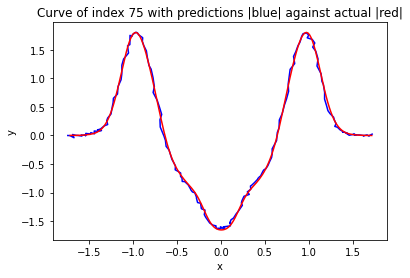

The loss of the curve 0.02750150116449825


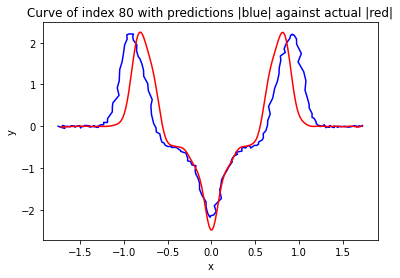

The loss of the curve 0.3177794214343495


In [14]:
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='swish')(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

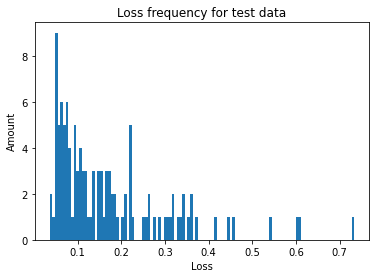

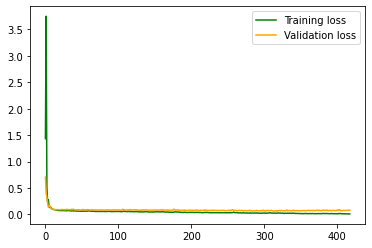

Loss average is: 0.17139751232923892
Loss mode is: [(0.22125, 1), (0.10257, 1), (0.61212, 1), (0.20123, 1), (0.07229, 1), (0.20819, 1), (0.1532, 1), (0.31675, 1), (0.06276, 1), (0.11957, 1)]
Loss median is: 0.12473
Used time: 320.9439640045166 seconds



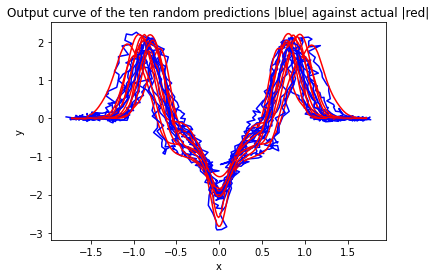

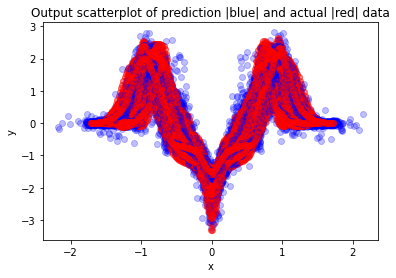

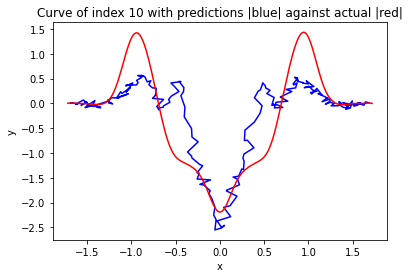

The loss of the curve 0.41400522036669146


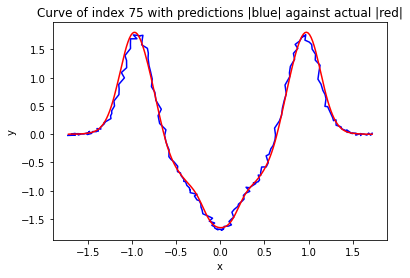

The loss of the curve 0.04976201786273378


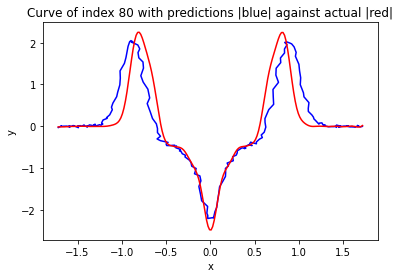

The loss of the curve 0.2869299234452127


In [15]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='swish')(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

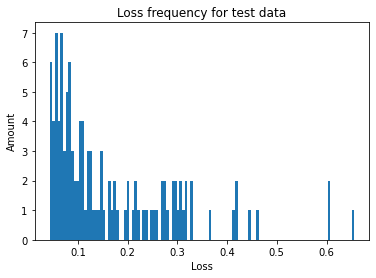

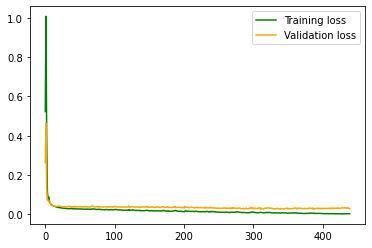

Loss average is: 0.16732994777130203
Loss mode is: [(0.22367, 1), (0.12287, 1), (0.21338, 1), (0.26836, 1), (0.08796, 1), (0.26889, 1), (0.24709, 1), (0.27516, 1), (0.04565, 1), (0.08857, 1)]
Loss median is: 0.11711
Used time: 340.4304254055023 seconds



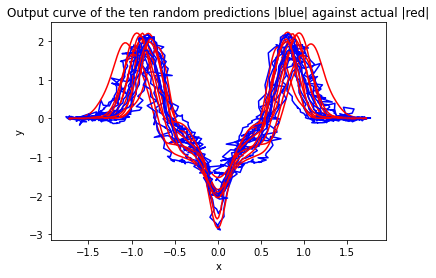

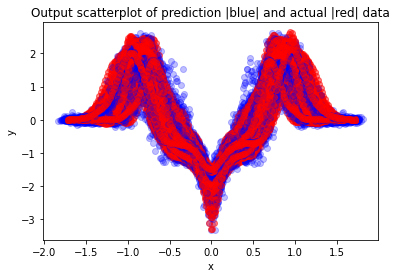

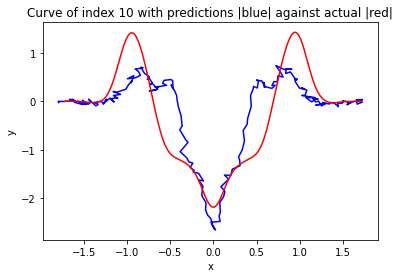

The loss of the curve 0.4176148016624666


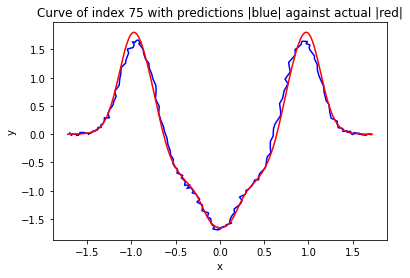

The loss of the curve 0.05686063822285962


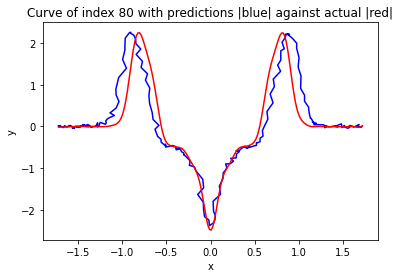

The loss of the curve 0.2899998294531772


In [16]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='swish')(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='swish')(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='huber_loss')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

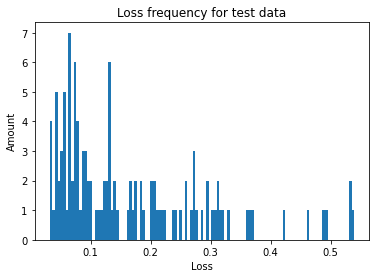

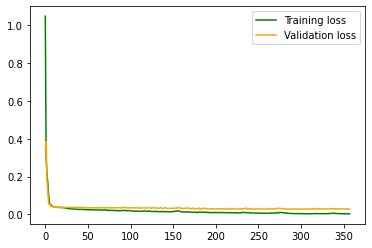

Loss average is: 0.1653669938150051
Loss mode is: [(0.27169, 1), (0.13053, 1), (0.36928, 1), (0.20365, 1), (0.04536, 1), (0.20178, 1), (0.28726, 1), (0.31363, 1), (0.06402, 1), (0.09936, 1)]
Loss median is: 0.12877
Used time: 272.34678649902344 seconds



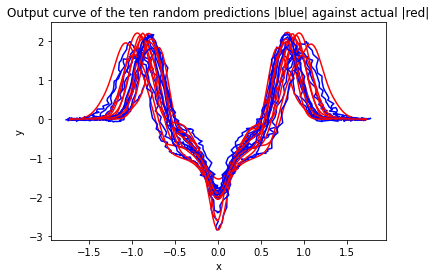

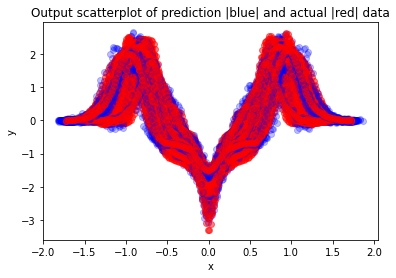

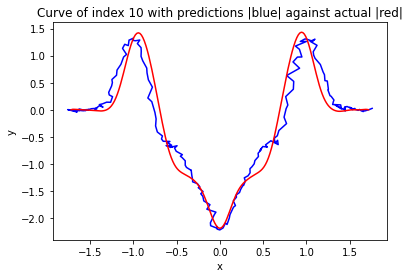

The loss of the curve 0.1865734250619024


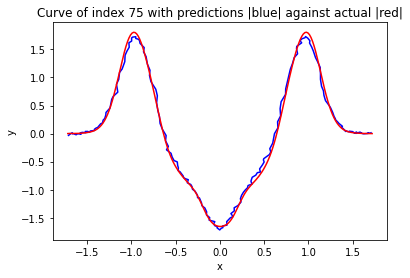

The loss of the curve 0.0409049144389371


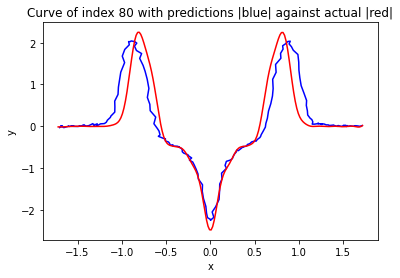

The loss of the curve 0.2748979362222319


In [18]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='log_cosh')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

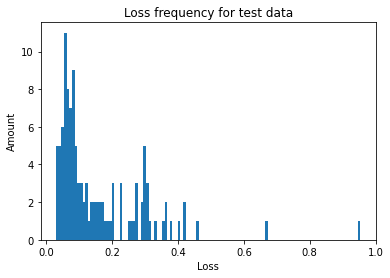

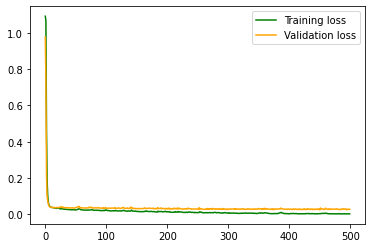

Loss average is: 0.15878977751997486
Loss mode is: [(0.25483, 1), (0.09109, 1), (0.15512, 1), (0.22339, 1), (0.14151, 1), (0.22246, 1), (0.06771, 1), (0.31611, 1), (0.06417, 1), (0.03247, 1)]
Loss median is: 0.0952
Used time: 384.1022140979767 seconds



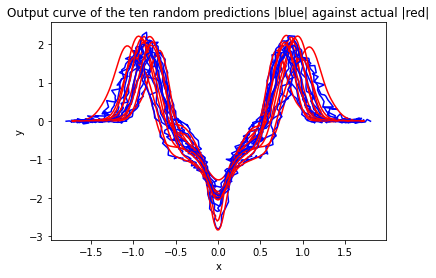

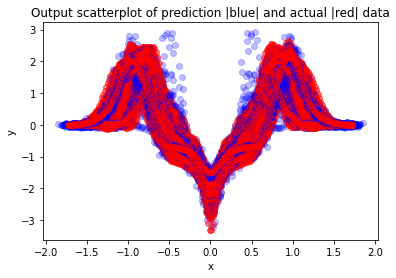

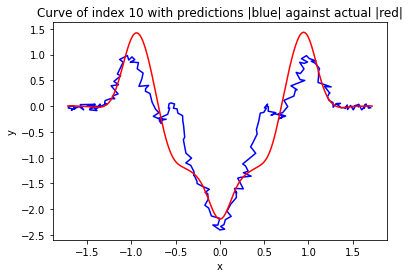

The loss of the curve 0.29370054605245083


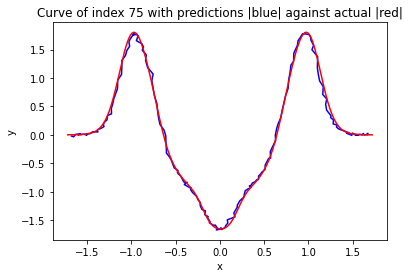

The loss of the curve 0.04334884857131814


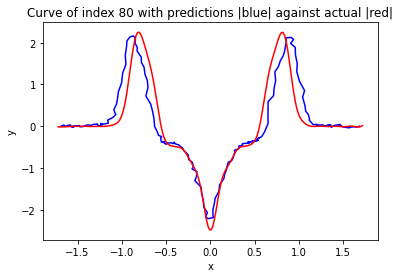

The loss of the curve 0.32685860585700427


In [19]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000)(inputs)
x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='log_cosh')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

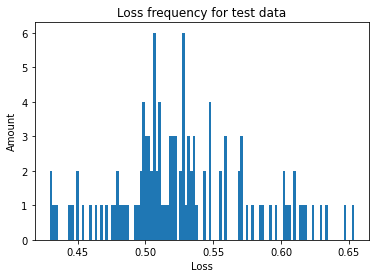

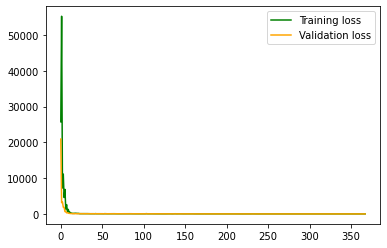

Loss average is: 0.5274803394389146
Loss mode is: [(0.50352, 2), (0.50693, 1), (0.49862, 1), (0.54841, 1), (0.61413, 1), (0.56001, 1), (0.61777, 1), (0.5282, 1), (0.55487, 1), (0.60973, 1)]
Loss median is: 0.52121
Used time: 282.5122787952423 seconds



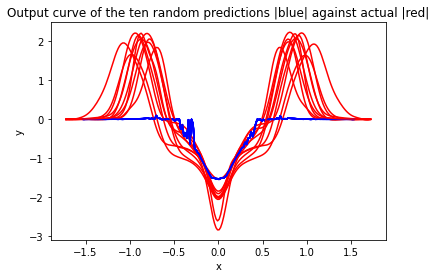

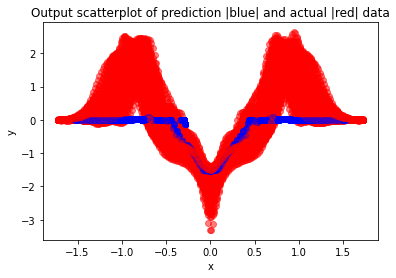

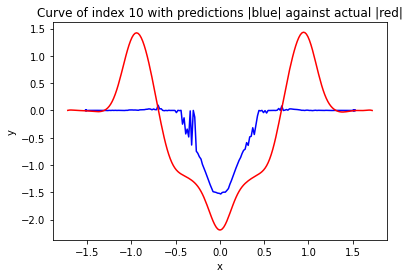

The loss of the curve 0.5708016552220836


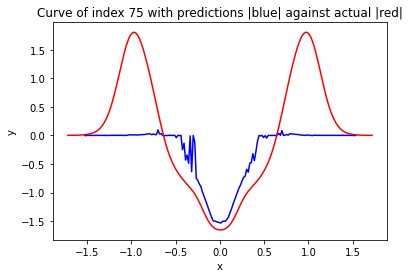

The loss of the curve 0.56967162707735


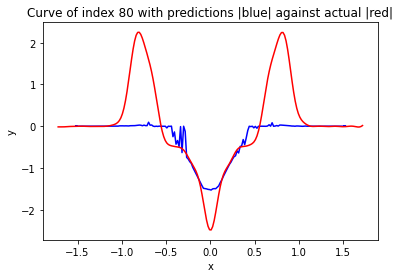

The loss of the curve 0.44615621954627327


In [20]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

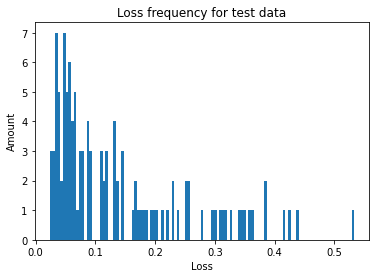

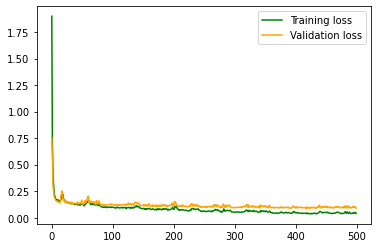

Loss average is: 0.1388615861980576
Loss mode is: [(0.22304, 1), (0.07572, 1), (0.34119, 1), (0.17516, 1), (0.02579, 1), (0.1723, 1), (0.05315, 1), (0.34889, 1), (0.05619, 1), (0.03669, 1)]
Loss median is: 0.09013
Used time: 381.18763422966003 seconds



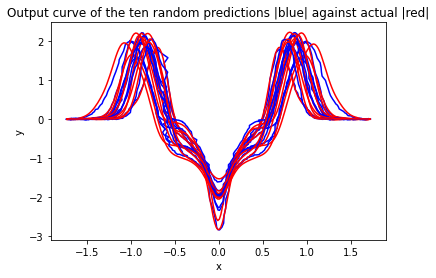

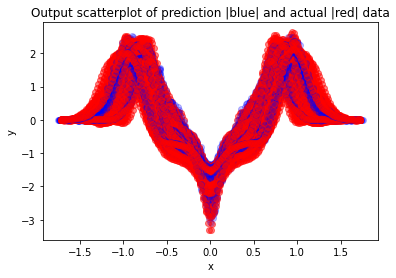

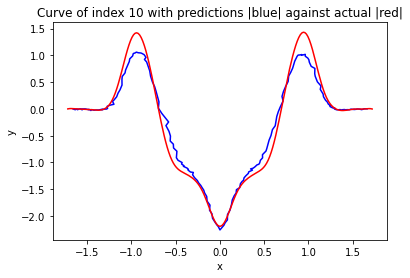

The loss of the curve 0.1204374038644544


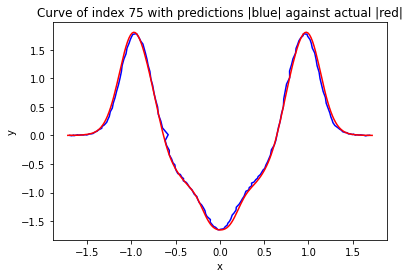

The loss of the curve 0.02536088954359348


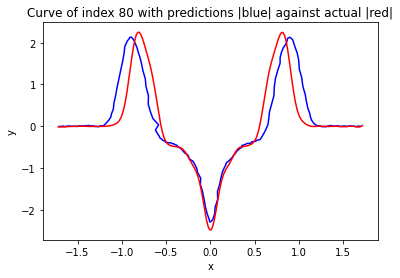

The loss of the curve 0.3145064512022178


In [21]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
#x = layers.LeakyReLU(alpha=0.1)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

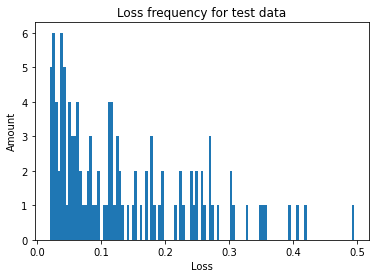

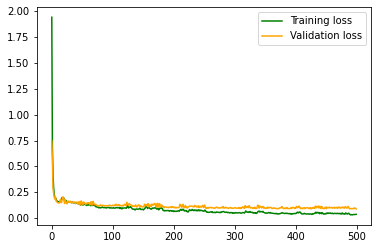

Loss average is: 0.13511420943822164
Loss mode is: [(0.11247, 2), (0.26113, 1), (0.13124, 1), (0.19556, 1), (0.27003, 1), (0.03702, 1), (0.2479, 1), (0.06267, 1), (0.18136, 1), (0.03815, 1)]
Loss median is: 0.10747
Used time: 378.56191658973694 seconds



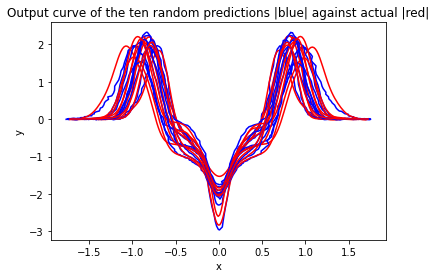

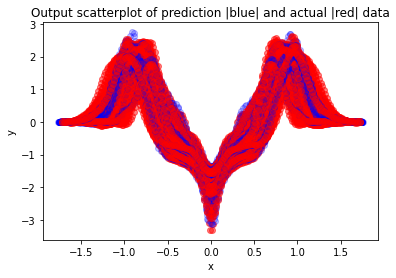

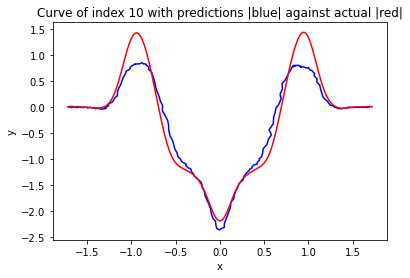

The loss of the curve 0.1559893291409198


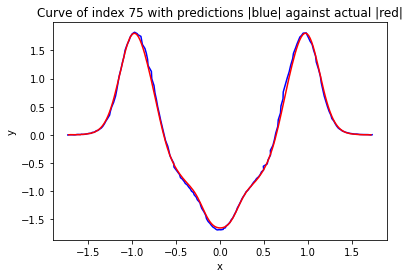

The loss of the curve 0.04121226068957089


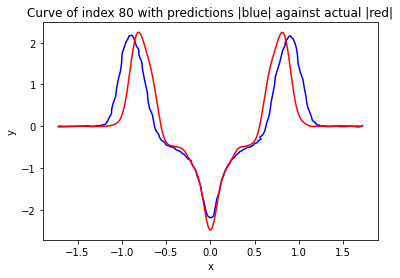

The loss of the curve 0.30762082029219084


In [22]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000)(inputs)
x = layers.ReLU(max_value = None, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = None, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = None, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = None, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

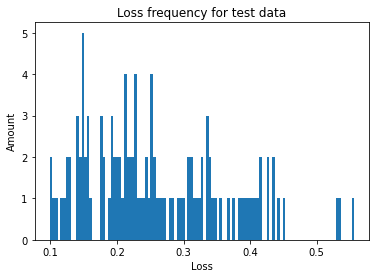

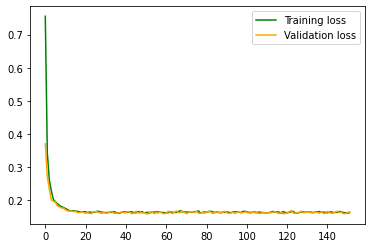

Loss average is: 0.2587157170750057
Loss mode is: [(0.22808, 1), (0.25249, 1), (0.24333, 1), (0.53024, 1), (0.29934, 1), (0.53401, 1), (0.25605, 1), (0.31223, 1), (0.4274, 1), (0.12899, 1)]
Loss median is: 0.23479
Used time: 121.40571713447571 seconds



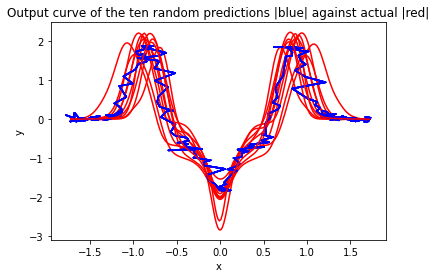

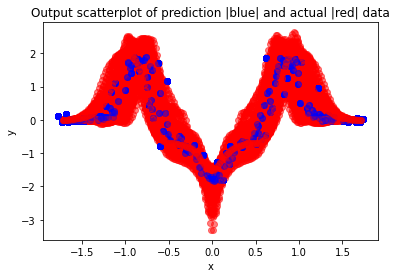

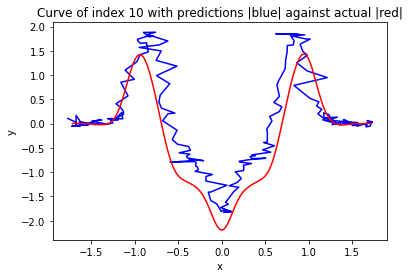

The loss of the curve 0.41502199679555757


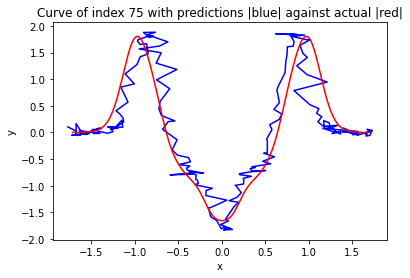

The loss of the curve 0.3205348864208621


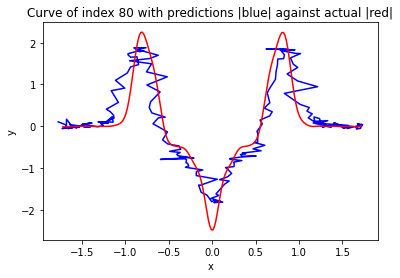

The loss of the curve 0.26952612945118465


In [23]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000)(inputs)
x = layers.ReLU(max_value = 1, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 1, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 1, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 1, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

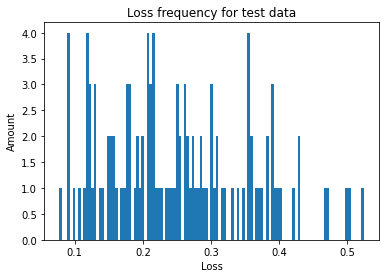

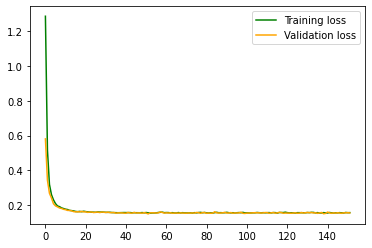

Loss average is: 0.24994317471160127
Loss mode is: [(0.19448, 1), (0.22006, 1), (0.20932, 1), (0.49885, 1), (0.26418, 1), (0.50191, 1), (0.28039, 1), (0.27869, 1), (0.3924, 1), (0.12408, 1)]
Loss median is: 0.23764
Used time: 122.29429721832275 seconds



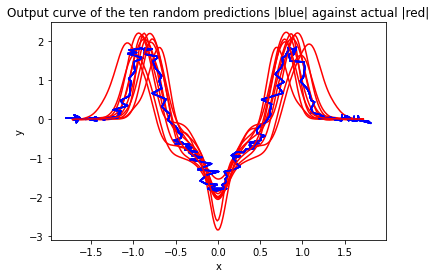

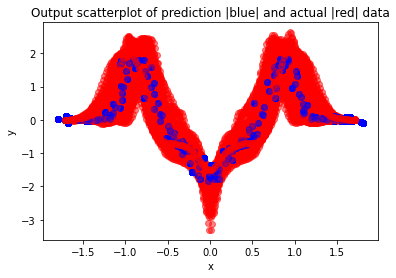

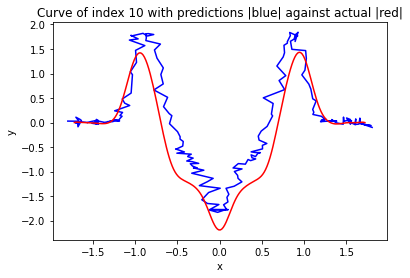

The loss of the curve 0.3827854135179245


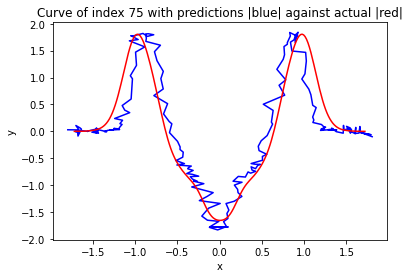

The loss of the curve 0.28602869534924263


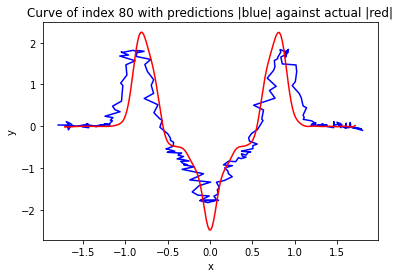

The loss of the curve 0.2938271549476302


In [24]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000)(inputs)
x = layers.ReLU(max_value = 2, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 2, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 2, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 2, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

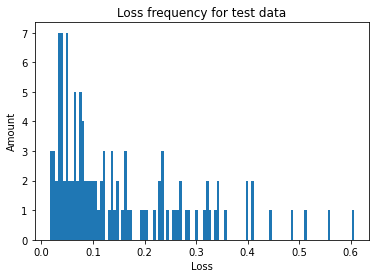

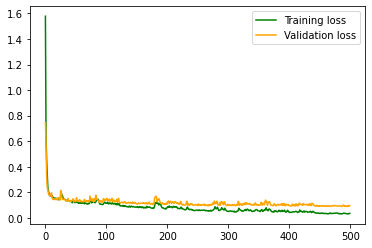

Loss average is: 0.15180494732865854
Loss mode is: [(0.25351, 1), (0.09933, 1), (0.07589, 1), (0.16576, 1), (0.14412, 1), (0.16001, 1), (0.05889, 1), (0.23667, 1), (0.03744, 1), (0.03626, 1)]
Loss median is: 0.09933
Used time: 396.5021426677704 seconds



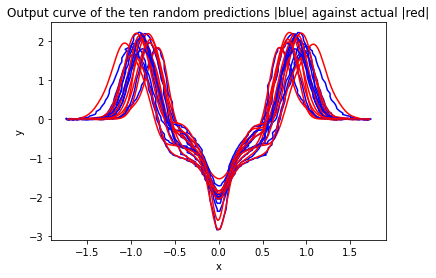

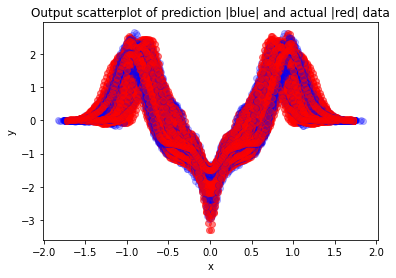

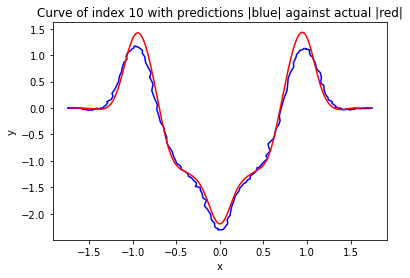

The loss of the curve 0.09126825062349887


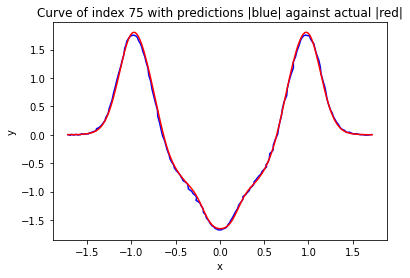

The loss of the curve 0.03307643891785996


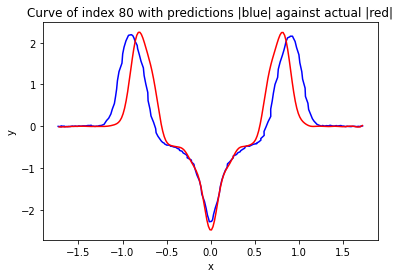

The loss of the curve 0.30177272885270534


In [25]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000)(inputs)
x = layers.ReLU(max_value = 10, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 10, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 10, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 10, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))

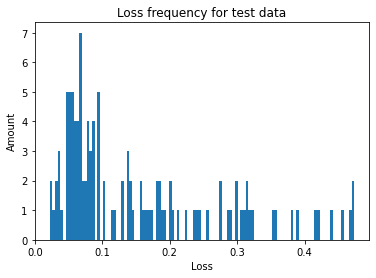

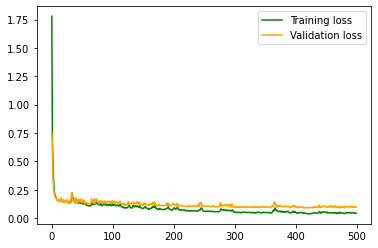

Loss average is: 0.15294155956660366
Loss mode is: [(0.16824, 1), (0.13654, 1), (0.38875, 1), (0.1813, 1), (0.102, 1), (0.19996, 1), (0.09282, 1), (0.29888, 1), (0.06244, 1), (0.0531, 1)]
Loss median is: 0.09468
Used time: 395.909056186676 seconds



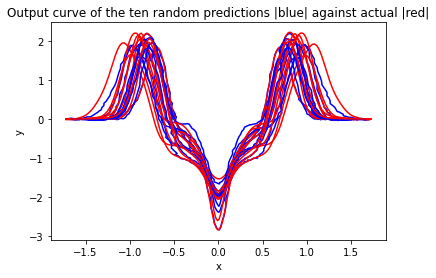

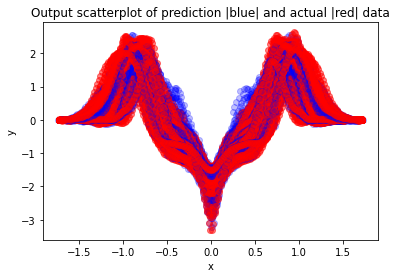

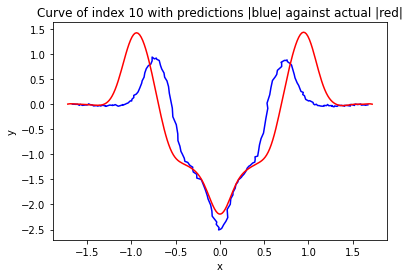

The loss of the curve 0.3530610696504903


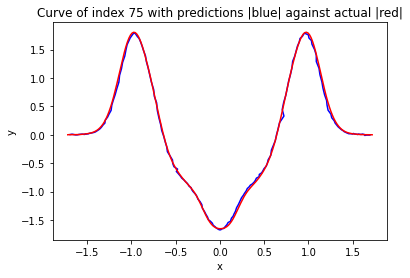

The loss of the curve 0.03529306867309162


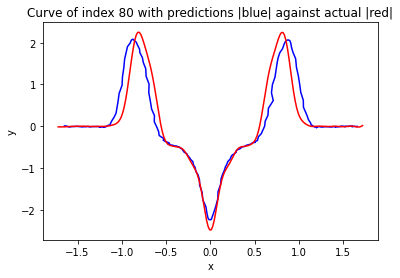

The loss of the curve 0.2983967827857325


In [26]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000)(inputs)
x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000)(x)
x = layers.ReLU(max_value = 20, negative_slope=0, threshold=0)(x)
#x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input_values, train_output_values, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output_values, model.predict(test_input_values))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output_values,model.predict(test_input_values))